# Imports

In [1]:
import random
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Read-ins

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [3]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cumsum'] = df_sciensano.D_tot.cumsum()

In [5]:
with open('../../data/interim/model_parameters/deterministic_2020-08-11.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']

# Functions

In [6]:
def model_run_to_df(start, end, simulation, variable, run):
    """
    Make dataframe with dates and simulation results, summed over all age layers
    
    Parameters
    ----------
    start : string 'YYYY-MM-DD'
        first date to save
    end : string 'YYYY-MM-DD'
        last date to save
    simulations : variable name
        name of model.sim output
    variable : string
        name of the variable, e.g. 'H_in'
    run : int
        number of the run
        
    """

    dates = pd.date_range(start, end)
    y_sum = simulation.sum(dim="stratification")
    results = y_sum[[variable]][variable].values[-len(dates):]
    df_sim = pd.DataFrame({'dates':dates, 'run'+str(run):results})
    return df_sim.set_index('dates')

In [7]:
def collect_runs(runs_dict):
    simulations = pd.concat(runs_dict, axis=1, ignore_index=True)
    simulations.columns = ['run'+str(i) for i in np.arange(1,len(simulations.columns)+1)]
    return simulations.reset_index()

# Predict hospitalised

In [ ]:
states = [['H_in']]
start_date = '15-03-2020'
end_date = '2021-01-01'
data=[df_sciensano[:samples_dict['end_ramp']]['H_in'].values]
dict_hosp={}
fig,ax=plt.subplots()
for i in range(100):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [start_date, '2020-09-01'], 
          'Nc':      [prevention*(Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure),
                      Nc_home + prevention*(Nc_schools + 0.7*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.7*Nc_leisure)]
          }
    y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
    dict_hosp[i] = model_run_to_df(start='2020-08-01', end='2021-01-01', simulation=y_model, variable='H_in',run=i)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = df_sciensano[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['H_in']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
simulations_hosp = collect_runs(dict_hosp)
simulations_hosp.to_csv('../../results/predictions_FAGG/UG_Sx_hospitalisations_20200801_20210101.csv')

In [ ]:
%matplotlib

# Predict hospitalised + ICU

In [11]:
y_model[]

<xarray.Dataset>
Dimensions:         (stratification: 9, time: 346)
Coordinates:
  * stratification  (stratification) int64 0 1 2 3 4 5 6 7 8
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 339 340 341 342 343 344 345
Data variables:
    S               (stratification, time) float64 1.305e+06 ... 6.273e+05
    E               (stratification, time) float64 1.0 0.7604 ... 0.05952
    I               (stratification, time) float64 0.0 0.2113 ... 0.03784
    A               (stratification, time) float64 0.0 0.0407 ... 0.04361
    M               (stratification, time) float64 0.0 0.01663 ... 0.09898
    ER              (stratification, time) float64 0.0 7.295e-07 ... 0.01033
    C               (stratification, time) float64 0.0 6.763e-08 ... 0.02491
    C_icurec        (stratification, time) float64 0.0 0.0 ... 0.001976 0.00196
    ICU             (stratification, time) float64 0.0 0.0 ... 0.006838 0.006781
    R               (stratification, time) float64 0.0 0.002951 ... 2.907e+04
    D               (stratification, time) float64 0.0 0.0 ... 2.423e+03
    SQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    MQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    H_in            (stratification, time) float64 0.0 6.268e-07 ... 0.003632
    H_out           (stratification, time) float64 0.0 1.512e-09 ... 0.004005
    H_tot           (stratification, time) float64 0.0 7.971e-07 ... 0.04398
Attributes:
    parameters:  {'beta': 0.03702535800417287, 'sigma': 3.2, 'omega': 2.0, 'z...

(0, 850)

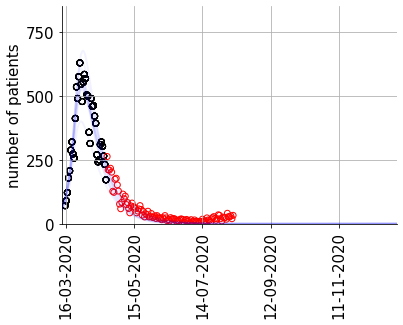

In [10]:
states = [['H_in'],['ICU']]
start_date = '15-03-2020'
end_date = '2021-01-01'
data=[df_sciensano[:samples_dict['end_ramp']]['H_in'].values]
dict_hosp={}
fig,ax=plt.subplots()
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [start_date, '2020-09-01'], 
          'Nc':      [prevention*(Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure),
                      Nc_home + prevention*(Nc_schools + 0.7*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.7*Nc_leisure)]
          }
    y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
    dict_hosp[i] = model_run_to_df(start='2020-08-01', end='2021-01-01', simulation=y_model, variable='H_in',run=i)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = df_sciensano[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['H_in']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
y_model[states[i]]

In [ ]:
%debug

# Predict deceased

Sciensano gives the total deceased (including nursery homes), but the model only predicts deceased from the hospital.

In [ ]:
states = [['D']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[df_sciensano[:samples_dict['end_ramp']]['D_cumsum'].values]
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [start_date], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = df_sciensano[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['D_cumsum']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
plt.title('Total deceased')
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [ ]:
fig,ax = plt.subplots()
df_sciensano.reset_index().plot('DATE','D_tot', ax=ax, label="total deceased")
deceased_hosp.plot('DATE','deceased_hosp', ax=ax, label='deceased in hospital')

In [ ]:
states = [['D']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[deceased_hosp.set_index('DATE')[:samples_dict['end_ramp']]['D_cumsum'].values]
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [start_date], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = deceased_hosp.set_index('DATE')[pd.to_datetime(samples_dict['end_ramp'])+pd.to_timedelta('1d'):end_date]['D_cumsum']
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
plt.title('Deceased in hospital')
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')